# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Stervende Zwaan\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\Stervende Zwaan\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\Stervende Zwaan\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [2]:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)]

outcomes = [TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]

## Linear regression

In [4]:
import numpy as np
from statistics import stdev 
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
import statsmodels.regression.linear_model as sm

xlimits = np.array([[0.015, 0.035], [0.0005, 0.003],[0.001, 0.004],[0.04, 0.08]])
sampling = LHS(xlimits=xlimits)

num = 200
x = sampling(num)

from collections import defaultdict

final= defaultdict(list)
mean = defaultdict(list)
StDev = defaultdict(list)

for tripple in x:
    for key in pred_prey(*tripple):
        outcome = pred_prey(*tripple)[key][0]
        final[key].append(outcome[-1])
        mean[key].append(outcome.mean())
        StDev[key].append(stdev(outcome))

In [5]:
results = sm.OLS(final['prey'], x).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.749
Model:                            OLS   Adj. R-squared (uncentered):              0.744
Method:                 Least Squares   F-statistic:                              146.4
Date:                Fri, 15 May 2020   Prob (F-statistic):                    9.95e-58
Time:                        13:08:27   Log-Likelihood:                         -847.18
No. Observations:                 200   AIC:                                      1702.
Df Residuals:                     196   BIC:                                      1716.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
results = sm.OLS(mean['prey'], x).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              1164.
Date:                Fri, 15 May 2020   Prob (F-statistic):                   2.41e-135
Time:                        13:08:27   Log-Likelihood:                         -639.64
No. Observations:                 200   AIC:                                      1287.
Df Residuals:                     196   BIC:                                      1300.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [7]:
results = sm.OLS(StDev['prey'], x).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              686.5
Date:                Fri, 15 May 2020   Prob (F-statistic):                   4.79e-114
Time:                        13:08:27   Log-Likelihood:                         -551.59
No. Observations:                 200   AIC:                                      1111.
Df Residuals:                     196   BIC:                                      1124.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Sobol

In [8]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    
    Python = Model('PredPreyPython', function=pred_prey)

    Python.uncertainties = uncertainties

    Python.outcomes = outcomes

In [9]:
with SequentialEvaluator(Python) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=100, uncertainty_sampling='sobol') 

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [10]:
def three_to_one_dimensions(outcome):
    d=dict()
    for i in outcome:
        a=[]
        for j in outcome[i]:
            a.extend(j[0])
        d.update({i : np.array(a)})
    return d

In [11]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import pandas as pd

outcomes_one = three_to_one_dimensions(outcomes)
problem = get_SALib_problem(Python.uncertainties)

### 50, 250, 1000 sample sizes

In [12]:
from IPython.core import display as ICD

for i in [50,250,1000]:
    Si = sobol.analyze(problem, outcomes_one['prey'][:i], calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    ICD.display(i,Si_df)

50

,ST,ST_conf,S1,S1_conf
predation_rate,0.002316,0.006194,0.017749,0.294499
predator_efficiency,0.009237,0.024659,0.035328,0.587439
predator_loss_rate,0.020720,0.055214,0.052731,0.878777
prey_birth_rate,0.036718,0.097674,0.069958,1.168475


250

,ST,ST_conf,S1,S1_conf
predation_rate,0.000398,0.000203,0.009435,0.012873
predator_efficiency,0.001593,0.000811,0.018722,0.025841
predator_loss_rate,0.003590,0.001828,0.027859,0.038902
prey_birth_rate,0.006393,0.003254,0.036843,0.052055


1000

,ST,ST_conf,S1,S1_conf
predation_rate,0.000057,0.000015,0.002035,0.001489
predator_efficiency,0.000228,0.000062,0.003957,0.002979
predator_loss_rate,0.000513,0.000139,0.005765,0.004469
prey_birth_rate,0.000911,0.000247,0.007459,0.005959


## Extra trees

In [13]:
def three_to_two_dimensions(outcome):
    d=dict()
    for i in outcome:
        a=[]
        for j in outcome[i]:
             a.append(j[0])
        d.update({i : np.array(a)})
    return d

In [14]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

x = experiments
y = three_to_two_dimensions(outcomes)

scores = get_feature_scores_all(x, y, alg='extra trees',mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


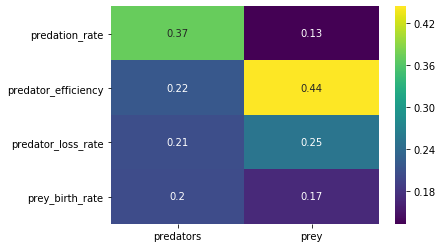

In [15]:
import seaborn as sns
sns.heatmap(scores,annot=True, cmap='viridis')
plt.show()